In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

df = pd.read_csv('../data/cleaned.csv')

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

monthly_sales = df.groupby(df['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()
monthly_sales = monthly_sales.sort_values('Order Date').reset_index(drop=True)

print("Monthly Sales Data:")
print(monthly_sales.head(10))
print(f"\nData spans from {monthly_sales['Order Date'].min()} to {monthly_sales['Order Date'].max()}")
print(f"Total months: {len(monthly_sales)}")

Monthly Sales Data:
  Order Date       Sales
0 2015-01-01  11631.8870
1 2015-02-01   4519.8920
2 2015-03-01  29067.3870
3 2015-04-01  23742.8050
4 2015-05-01  20928.3730
5 2015-06-01  31056.5596
6 2015-07-01  23416.3090
7 2015-08-01  27117.5365
8 2015-09-01  46874.6278
9 2015-10-01  28717.4410

Data spans from 2015-01-01 00:00:00 to 2018-12-01 00:00:00
Total months: 48


In [2]:
def create_features(data):
    features_df = data.copy()
    
    features_df['month_sequence'] = range(1, len(features_df) + 1)
    features_df['month'] = features_df['Order Date'].dt.month
    month_dummies = pd.get_dummies(features_df['month'], prefix='month', drop_first=True)
    features_df = pd.concat([features_df, month_dummies], axis=1)
    
    return features_df

data_with_features = create_features(monthly_sales)
print("\nFeatures created:")
print(data_with_features.columns.tolist())
print("\nFirst few rows with features:")
print(data_with_features.head())


Features created:
['Order Date', 'Sales', 'month_sequence', 'month', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

First few rows with features:
  Order Date      Sales  month_sequence  month  month_2  month_3  month_4  \
0 2015-01-01  11631.887               1      1    False    False    False   
1 2015-02-01   4519.892               2      2     True    False    False   
2 2015-03-01  29067.387               3      3    False     True    False   
3 2015-04-01  23742.805               4      4    False    False     True   
4 2015-05-01  20928.373               5      5    False    False    False   

   month_5  month_6  month_7  month_8  month_9  month_10  month_11  month_12  
0    False    False    False    False    False     False     False     False  
1    False    False    False    False    False     False     False     False  
2    False    False    False    False    False     False     False     Fals

In [3]:
feature_columns = [col for col in data_with_features.columns if col.startswith('month_')]
X = data_with_features[feature_columns]
y = data_with_features['Sales']

train_size = len(X) - 12
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTraining set: {len(X_train)} months")
print(f"Test set: {len(X_test)} months")


Training set: 36 months
Test set: 12 months


In [4]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_test = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("Linear Regression Model Performance:")
print("=" * 40)
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Square Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Print model coefficients
print("\nModel Coefficients:")
print("=" * 40)
print(f"Intercept: ${lr_model.intercept_:,.2f}")
print(f"Trend (month_sequence): ${lr_model.coef_[0]:,.2f} per month")

print("\nSeasonality Coefficients (relative to January):")
for i, coef in enumerate(lr_model.coef_[1:], 2):
    month_name = pd.to_datetime(f"2023-{i:02d}-01").strftime("%B")
    print(f"{month_name}: ${coef:,.2f}")

Linear Regression Model Performance:
Mean Absolute Error (MAE): $7,796.29
Root Mean Square Error (RMSE): $9,417.78
R-squared (R²): 0.8069
Mean Absolute Percentage Error (MAPE): 17.80%

Model Coefficients:
Intercept: $9,354.27
Trend (month_sequence): $335.31 per month

Seasonality Coefficients (relative to January):
February: $-4,662.50
March: $12,885.39
April: $13,168.87
May: $11,154.51
June: $12,553.31
July: $11,876.79
August: $12,509.95
September: $37,534.52
October: $13,076.63
November: $43,622.08
December: $47,724.98


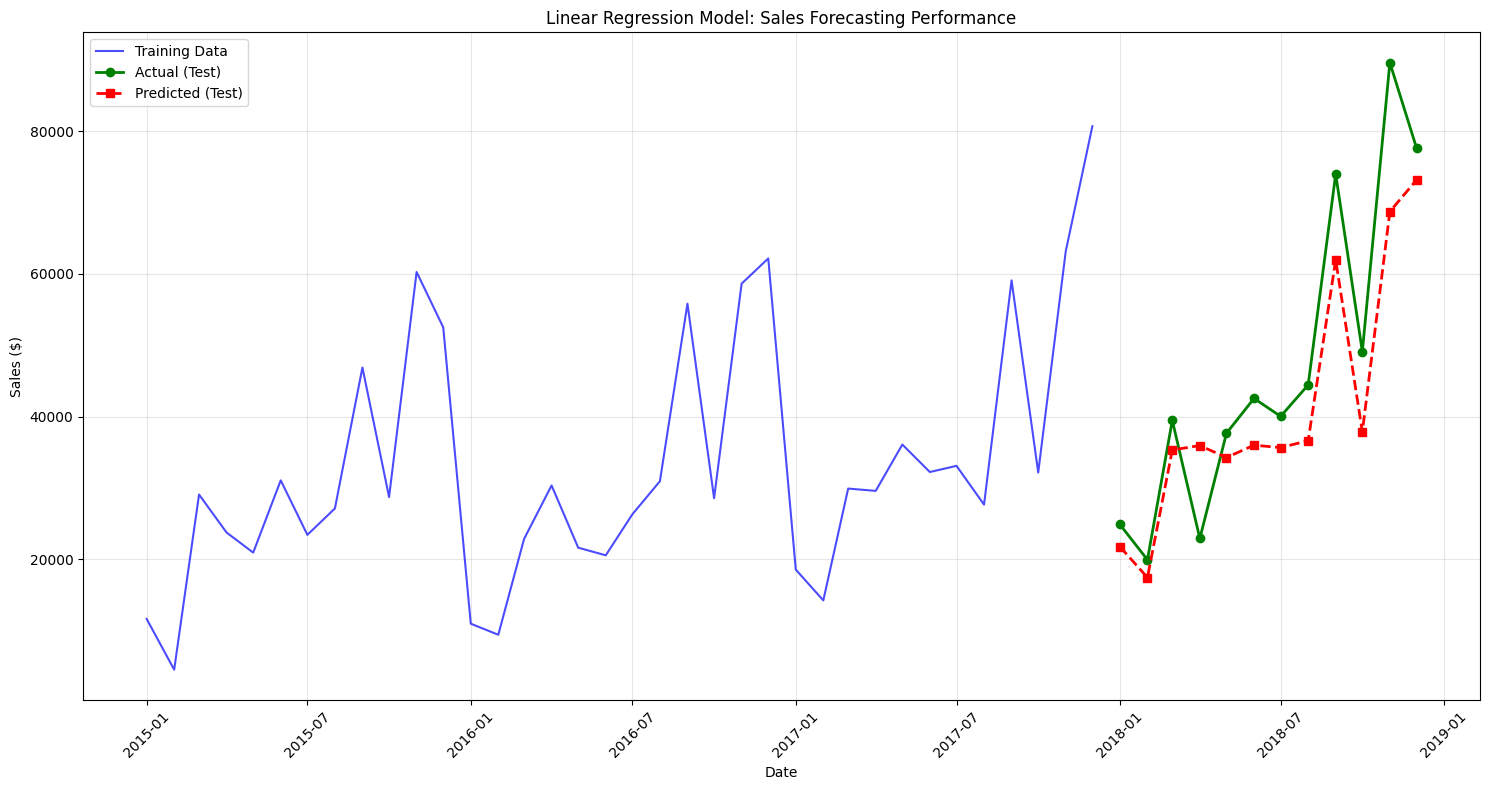


Test Period Performance:
Date               Actual    Predicted        Error    Error %
2018-01      $    24,869 $    21,761 $     3,108     12.5%
2018-02      $    19,921 $    17,433 $     2,488     12.5%
2018-03      $    39,464 $    35,317 $     4,147     10.5%
2018-04      $    22,909 $    35,935 $   -13,026    -56.9%
2018-05      $    37,662 $    34,256 $     3,406      9.0%
2018-06      $    42,546 $    35,990 $     6,556     15.4%
2018-07      $    40,030 $    35,649 $     4,381     10.9%
2018-08      $    44,436 $    36,618 $     7,819     17.6%
2018-09      $    73,989 $    61,978 $    12,012     16.2%
2018-10      $    49,096 $    37,855 $    11,241     22.9%
2018-11      $    89,613 $    68,736 $    20,877     23.3%
2018-12      $    77,670 $    73,174 $     4,496      5.8%


In [5]:
# Plot actual vs predicted for test period
plt.figure(figsize=(15, 8))

# Plot training period
train_dates = data_with_features['Order Date'][:train_size]
plt.plot(train_dates, y_train, 'b-', label='Training Data', alpha=0.7)

# Plot test period
test_dates = data_with_features['Order Date'][train_size:]
plt.plot(test_dates, y_test, 'g-', label='Actual (Test)', marker='o', linewidth=2)
plt.plot(test_dates, y_pred_test, 'r--', label='Predicted (Test)', marker='s', linewidth=2)

plt.title('Linear Regression Model: Sales Forecasting Performance')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print comparison table
print("\nTest Period Performance:")
print("=" * 60)
print(f"{'Date':<12} {'Actual':>12} {'Predicted':>12} {'Error':>12} {'Error %':>10}")
print("=" * 60)
for i, (date, actual, pred) in enumerate(zip(test_dates, y_test, y_pred_test)):
    error = actual - pred
    error_pct = (error / actual) * 100
    print(f"{date.strftime('%Y-%m'):<12} ${actual:>10,.0f} ${pred:>10,.0f} ${error:>10,.0f} {error_pct:>8.1f}%")

In [6]:
# Generate future forecasts
def generate_forecasts(model, last_date, num_months=12):
    """Generate future sales forecasts"""
    forecasts = []
    
    # Get the last month sequence number
    last_month_seq = len(data_with_features)
    
    for i in range(1, num_months + 1):
        # Calculate future date
        future_date = last_date + pd.DateOffset(months=i)
        
        # Create feature vector
        month_seq = last_month_seq + i
        month_num = future_date.month
        
        # Create feature row
        feature_row = [month_seq]  # trend
        
        # Add month dummies (months 2-12, since January is dropped)
        for month in range(2, 13):
            feature_row.append(1 if month_num == month else 0)
        
        # Make prediction
        prediction = model.predict([feature_row])[0]
        
        forecasts.append({
            'Date': future_date,
            'Predicted_Sales': prediction,
            'Month': future_date.strftime('%B %Y')
        })
    
    return pd.DataFrame(forecasts)

# Generate 12-month forecast
last_date = monthly_sales['Order Date'].max()
forecast_df = generate_forecasts(lr_model, last_date, 12)

print("12-Month Sales Forecast:")
print("=" * 50)
for _, row in forecast_df.iterrows():
    print(f"{row['Month']:<15}: ${row['Predicted_Sales']:>10,.0f}")

print(f"\nTotal Forecast (12 months): ${forecast_df['Predicted_Sales'].sum():,.0f}")
print(f"Average Monthly Forecast: ${forecast_df['Predicted_Sales'].mean():,.0f}")

12-Month Sales Forecast:
January 2019   : $    25,784
February 2019  : $    21,457
March 2019     : $    39,340
April 2019     : $    39,959
May 2019       : $    38,280
June 2019      : $    40,014
July 2019      : $    39,673
August 2019    : $    40,641
September 2019 : $    66,001
October 2019   : $    41,879
November 2019  : $    72,759
December 2019  : $    77,198

Total Forecast (12 months): $542,986
Average Monthly Forecast: $45,249


/Users/skylarrrr/Documents/Skylar's Space/School/AUPP/Machine Learning/Final Project/ML---Final-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/skylarrrr/Documents/Skylar's Space/School/AUPP/Machine Learning/Final Project/ML---Final-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/skylarrrr/Documents/Skylar's Space/School/AUPP/Machine Learning/Final Project/ML---Final-Project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/skylarrrr/Documents/Skylar's Space/School/AUPP/Machine Learning/Final Project/ML---Final-Project/.venv/lib/python3.9/site-p